<a href="https://colab.research.google.com/github/houman44/imperial-capstone-project/blob/main/Self_Study_Try_it_12_2_Exploring_Bayesian_optimization_and_surrogate_models_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Self-study try-it activity 12.2: Applying surrogate models to guide decision-making in Bayesian optimisation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

## Introduction

In this notebook, you’ll revisit key ideas from the module with a focus on black box optimisation. By manually selecting queries, you’ll build intuition for how Bayesian optimisation works.

You'll begin with the Bayesian optimisation problem, where you take on the optimiser’s role. This helps reveal why the problem is hard and what kinds of strategies might help solve it. You’ll then explore surrogate models as tools that represent your belief and uncertainty about the black box function. With a surrogate in place, choosing the next query becomes more manageable. As you work through the examples, you’ll likely start forming your own rules for picking queries. These rules can be formalised into acquisition functions.

By the end, you'll define and analyse two new acquisition functions, testing how they trade off between exploration and exploitation.

## The Bayesian optimisation problem

Bayesian optimisation addresses the problem of maximising expensive black box functions. In particular, your goal is to find:

$$x_* = \arg\max f(x)$$

You don’t know anything about the function in advance, but you can query it at any input $x$. The challenge is to get as close as possible to the maximum using as few queries as possible.

To build intuition for the problem and how you might solve it, try the following exercise.

When running the cell, you’ll be asked to enter a value between zero and one. You have ten attempts to maximise an unknown function. Because it’s a black box, you’ll only see the inputs you’ve chosen,
$x_i$, and the outputs, $f(x_i)$. You can rerun the cell as many times as you like. As you go, consider the following:

1. How is this different from classical optimisation? (Hint: can you use gradients?)

2. What are the main difficulties you encounter when optimising?

3. What strategies help you improve over multiple runs?

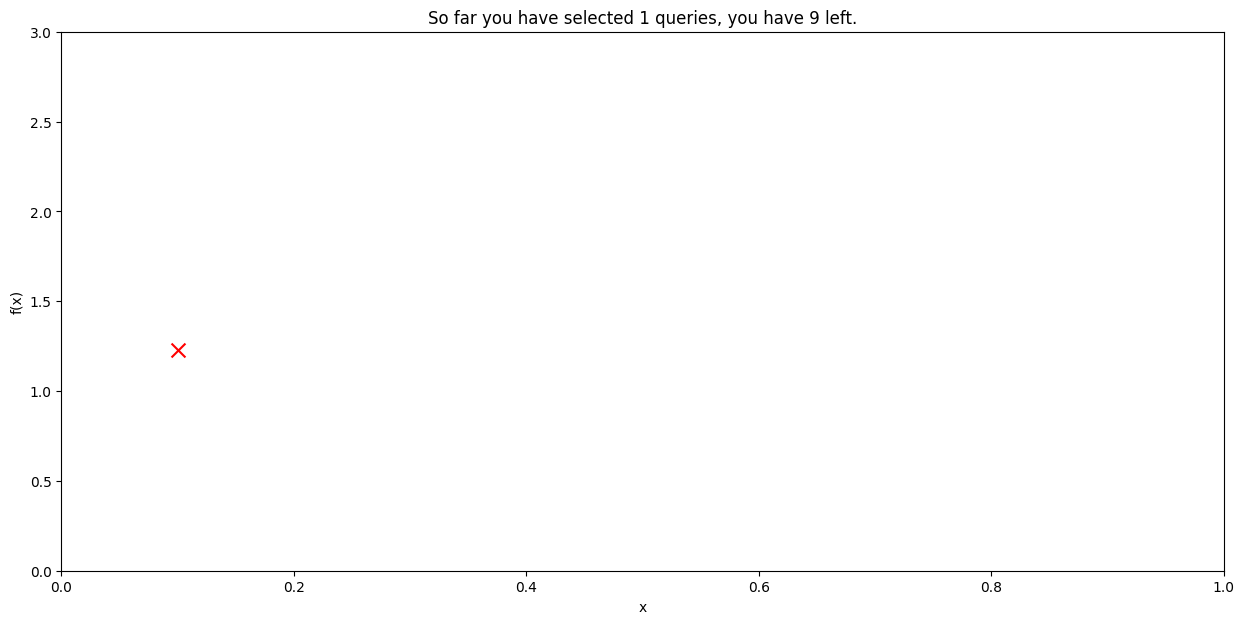

Data so far (sorted by descending observations): 
1: (x, f(x)) = ('0.10', '1.2282')


KeyboardInterrupt: Interrupted by user

In [3]:
#Draw random function parameters
modes = np.random.randint(1, 5)
std = np.random.uniform(low = 0.005, high = 0.05, size = modes)
means = np.random.uniform(size = modes)
amps = np.random.uniform(size = modes) * (2 - 1) + 1

#Define function
def calc_function(x):
  exp = -(x - means) ** 2 / std
  y = amps * np.exp(exp)
  return np.sum(y)

#Initialise query lists and maximum observations
X, Y = [], []
max_obs = 0

#Number of queries in the optimisation loop
num_queries = 10

for i in range(0, num_queries):
  #Clear the outputs to keep the interface clean
  clear_output(wait = True)
  #Initialise plots
  fig, ax = plt.subplots(figsize = (15, 7))
  #Set the x and y limits, labels and dynamic title
  ax.set_xlim(0, 1)
  ax.set_ylim(0, max(max_obs + 1, 3))
  ax.set_ylabel('f(x)')
  ax.set_xlabel('x')
  ax.set_title('So far you have selected ' + str(i) + ' queries, you have ' + str(10 - i) + ' left.' )
  #Plot queries and show the plot
  ax.scatter(X, Y, c = 'r', marker='x', s = 100)
  plt.show()
  #Initialise x
  x = -1
  #Select a display format for X and Y
  X_format =  ['%.2f' % query for query in X] #Two sig figs
  Y_format = ['%.4f' % obs for obs in Y] #Four sig figs

  while not (0 <= x <= 1): #Condition to ensure a number between zero and one is chosen
    data = [(query, obs) for query, obs in zip(X_format, Y_format)]
    print('Data so far (sorted by descending observations): ')
    print('\n'.join('{}: (x, f(x)) = {}'.format(*k) for k in enumerate(data, start = 1))) #Display data
    x = float(input('Pick a number between 0 and 1: '))
  #Append data, calculate function and sort lists according to observation values
  X.append(x)
  y = calc_function(x)
  Y.append(y)
  X = [x for _, x in sorted(zip(Y, X), reverse = True)]
  Y.sort(reverse = True)
  max_obs = max(max_obs, y)

clear_output()

#Calculate function in the grid [0, 0.01, 0.02, ..., 0.98, 0.99, 1]
x_grid = np.linspace(0, 1, 1001)
y_real = []
best_obs_grid = 0
for x in x_grid:
  y = calc_function(x)
  y_real.append(y)
  best_obs_grid = max(best_obs_grid, y) #Keep track of the best observation


#Final plot and display
fig, ax = plt.subplots(figsize = (15, 7))
ax.plot(x_grid, y_real, 'k', label = 'f(x)')
ax.scatter(X, Y, c = 'r', marker = 'x', label = 'Queries', s = 100)
ax.set_ylabel('f(x)')
ax.set_xlabel('x')
ax.set_xlim(0, 1)
ax.set_title('Real function and all queries')
plt.show()
print('Maximum (by Grid-Search):')
print(best_obs_grid)
print('Best by Yourself:')
print(max_obs)

### Question 1

Use the following quadratic function and rerun the code cell above for Bayesian optimisation problem:

$$-4(x - 0.5)^2 + 1$$

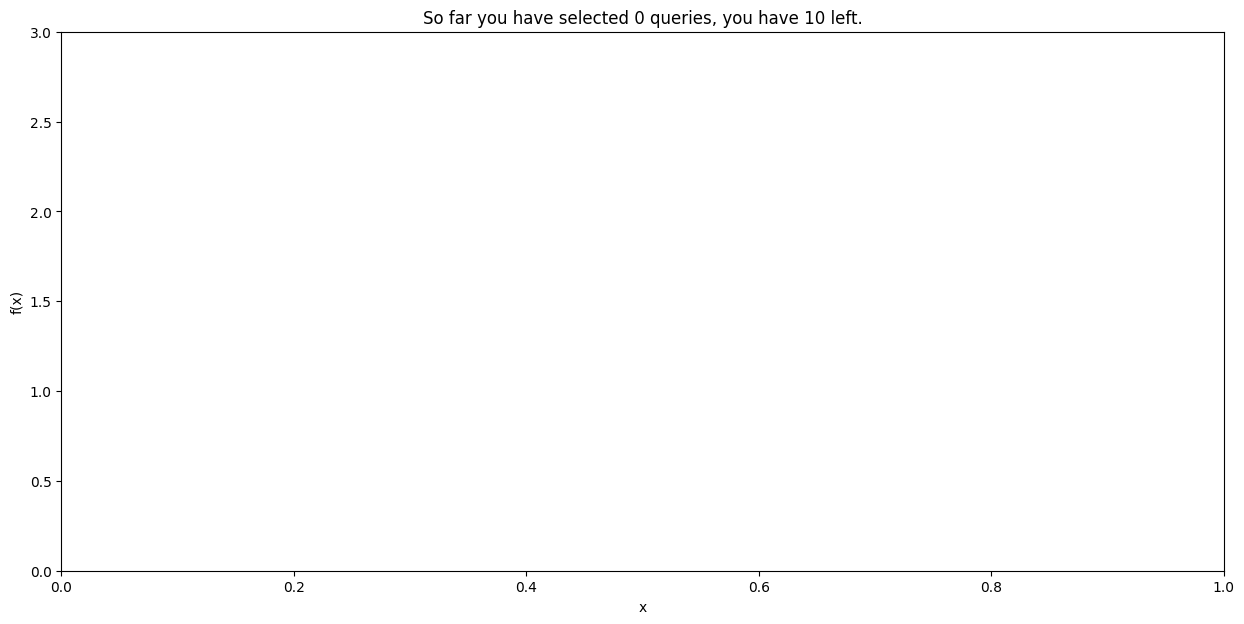

Data so far (sorted by descending observations): 



KeyboardInterrupt: Interrupted by user

In [5]:
###Enter your code here
#Draw random function parameters
from sklearn.gaussian_process.kernels import RationalQuadratic, WhiteKernel

modes = np.random.randint(1, 5)
std = np.random.uniform(low = 0.005, high = 0.05, size = modes)
means = np.random.uniform(size = modes)
amps = np.random.uniform(size = modes) * (2 - 1) + 1

#Define function
def calc_function(x):
  exp = -(x - means) ** 2 / std
  y = amps * np.exp(exp)
  return np.sum(y)

#Initialise query lists and maximum observations
X, Y = [], []
max_obs = 0

def quadratic_objective(x):

    return -4 * (x - 0.5)**2 + 1

# Initialize GP model (Using Matern kernel as in our previous discussion)
kernel = RationalQuadratic(length_scale=1.0, alpha=1.0) + WhiteKernel(noise_level=0.01)

gp = GaussianProcessRegressor(kernel=kernel, alpha=0.0)

# --- Simulate the first 5 random observations (Exploration phase) ---
np.random.seed(42)
X_obs = np.random.uniform(0, 1, 5).reshape(-1, 1)
y_obs = np.array([quadratic_objective(x) for x in X_obs])

gp.fit(X_obs, y_obs)



#Number of queries in the optimisation loop
num_queries = 10

for i in range(0, num_queries):
  #Clear the outputs to keep the interface clean
  clear_output(wait = True)
  #Initialise plots
  fig, ax = plt.subplots(figsize = (15, 7))
  #Set the x and y limits, labels and dynamic title
  ax.set_xlim(0, 1)
  ax.set_ylim(0, max(max_obs + 1, 3))
  ax.set_ylabel('f(x)')
  ax.set_xlabel('x')
  ax.set_title('So far you have selected ' + str(i) + ' queries, you have ' + str(10 - i) + ' left.' )
  #Plot queries and show the plot
  ax.scatter(X, Y, c = 'r', marker='x', s = 100)
  plt.show()
  #Initialise x
  x = -1
  #Select a display format for X and Y
  X_format =  ['%.2f' % query for query in X] #Two sig figs
  Y_format = ['%.4f' % obs for obs in Y] #Four sig figs

  while not (0 <= x <= 1): #Condition to ensure a number between zero and one is chosen
    data = [(query, obs) for query, obs in zip(X_format, Y_format)]
    print('Data so far (sorted by descending observations): ')
    print('\n'.join('{}: (x, f(x)) = {}'.format(*k) for k in enumerate(data, start = 1))) #Display data
    x = float(input('Pick a number between 0 and 1: '))
  #Append data, calculate function and sort lists according to observation values
  X.append(x)
  y = calc_function(x)
  Y.append(y)
  X = [x for _, x in sorted(zip(Y, X), reverse = True)]
  Y.sort(reverse = True)
  max_obs = max(max_obs, y)

clear_output()

#Calculate function in the grid [0, 0.01, 0.02, ..., 0.98, 0.99, 1]
x_grid = np.linspace(0, 1, 1001)
y_real = []
best_obs_grid = 0
for x in x_grid:
  y = calc_function(x)
  y_real.append(y)
  best_obs_grid = max(best_obs_grid, y) #Keep track of the best observation


#Final plot and display
fig, ax = plt.subplots(figsize = (15, 7))
ax.plot(x_grid, y_real, 'k', label = 'f(x)')
ax.scatter(X, Y, c = 'r', marker = 'x', label = 'Queries', s = 100)
ax.set_ylabel('f(x)')
ax.set_xlabel('x')
ax.set_xlim(0, 1)
ax.set_title('Real function and all queries')
plt.show()
print('Maximum (by Grid-Search):')
print(best_obs_grid)
print('Best by Yourself:')
print(max_obs)


## Surrogate models

By the end of the previous exercise, you may have started to develop a strategy that balances exploration and exploitation. You explore regions where you know little about the function, and you exploit areas where you’ve already observed high values by refining your search nearby.

Surrogate models allow you to design algorithms that follow this kind of logic. They offer a way to represent both your belief about the unknown function and your uncertainty. The most common example is the Gaussian process (GP).

A GP defines a distribution over functions. It’s specified by a mean function and a positive semi-definite kernel. To formalise this, consider a space $\mathcal{X}$, a function $\mu: \mathcal{X} \rightarrow \mathbb{R}$ and a *positive semi-definite* function $\kappa : \mathcal{X} \times \mathcal{X} \rightarrow \mathbb{R}$.

You can say that $f$ follows a GP prior with mean function $\mu$ and kernel $\kappa$ if, for any $n \in \mathbb{N}$ and any set of distinct points $(x_1, x_2, ..., x_n) := x$, $x_i \in \mathcal{X}$, the random vector $(f(x_1), ..., f(x_n))$ is normally distributed with mean vector $m(x)$ and covariance matrix $K(x)$, where:

$$
m(x)_i = \mu(x_i)
$$

$$
K(x)_{i, j} = \kappa(x_i, x_j)
$$​

This can be written compactly as: $f \sim \mathcal{GP}(\mu(x), \kappa(x))$

One major advantage of GPs is that you can compute the posterior distribution analytically, even when the observations are noisy. Suppose your observed data follows the model:

$$
 y = f(x) + \epsilon
$$

where $\epsilon \sim \text{Normal}(0, \sigma_e^2)$ is Gaussian noise.

Assume $f \sim \mathcal{GP}(\mu_0, \kappa_0)$, and you are given a data set of queries and observations, $D_n = \{ (x_i, y_i) : i = 1, ..., n \}$. Then the posterior distribution $f \ | \ D_n$ is also a GP, with the following posterior mean and covariance functions:


$$
    m_n(x) = \mu_0(x) + k(x)^T( K + \sigma^2 I )^{-1} (Y - m)
$$

$$
    s^2_n(x, x') = \kappa_0(x, x') - k(x)^T ( K + \sigma^2 I ) ^{-1} k(x')
$$

where: $m_i = \mu_0(x_i), Y_i = y_i, k(x)_i = \kappa_0(x, x_i), K_{ij} = \kappa_0(x_i, x_j)$

You’ll now repeat the earlier exercise, this time with a GP surrogate fitted to your observed queries. The model uses an radial basis function (RBF) kernel, which depends on a length scale parameter. You’ll have the chance to adjust this and see how it influences the behaviour of the model.

As you work through the exercise, consider the following:

1. How do you interpret the model? How does it update in response to new observations? Why might zero be a sensible choice for the prior mean?

2. Can you define a rule for selecting the next query using only the GP posterior (without manual input)?

3. Try changing the model parameters (see the top of the code cell). How does the length scale affect the model’s confidence and predictions? How does it respond to noisy data?

Note: In practice, hyperparameters such as the kernel length scale are often learned using maximum likelihood. Here, they’re fixed to help you focus on understanding their effects.

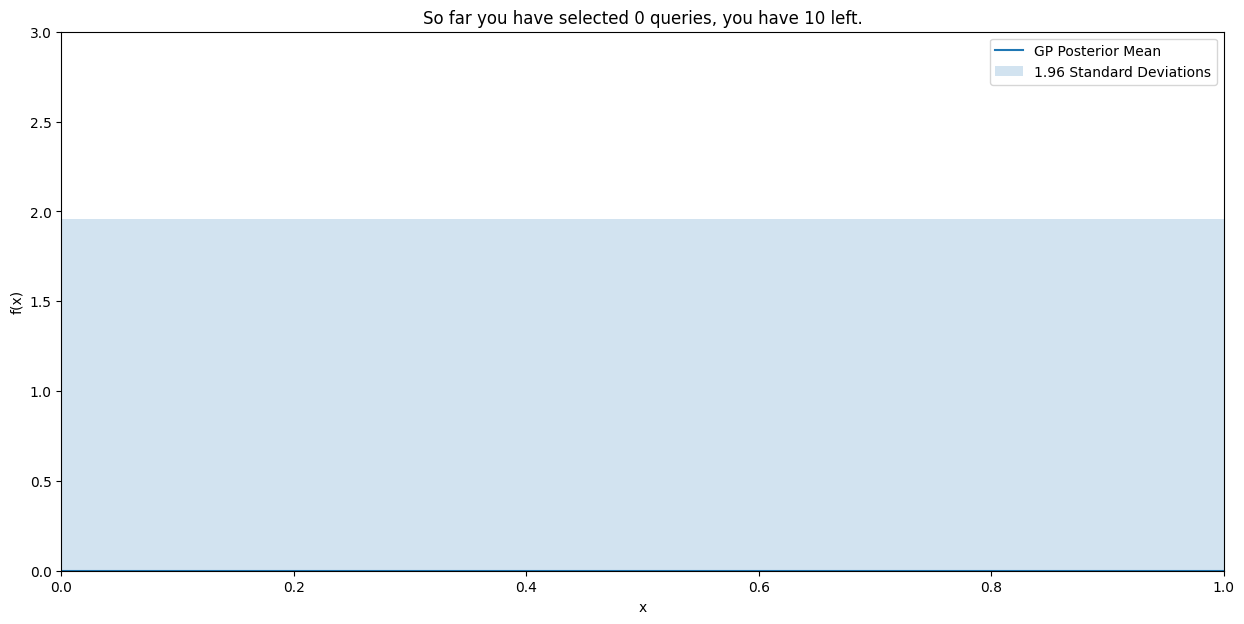

Data so far (sorted by descending observations): 



KeyboardInterrupt: Interrupted by user

In [6]:
#Parameters of the problem. Feel free to change them and play around with
real_noise_std = 1e-10 #Real noise needs to be positive for code to work, instead of zero set 1e-10
noise_assumption = 1e-10 #Noise assumption, a hyperparameter

rbf_lengthscale = 0.1 #Length scale parameter

#Draw random function parameters
modes = np.random.randint(1, 5)
std = np.random.uniform(low = 0.005, high = 0.05, size = modes)
means = np.random.uniform(size = modes)
amps = np.random.uniform(size = modes) * (2 - 1) + 1

#Define function
def calc_function(x):
  exp = -(x - means) ** 2 / std
  y = amps * np.exp(exp)
  return np.sum(y)

#Define the kernel of the GP
kernel = RBF(length_scale=rbf_lengthscale, length_scale_bounds='fixed')
model = GaussianProcessRegressor(kernel = kernel, alpha=noise_assumption)
#Standard deviation for plot
beta = 1.96

#Define function
def calc_function(x):
  exp = -(x - means) ** 2 / std
  y = amps * np.exp(exp)
  return np.sum(y)
#Initialise query lists and maximum observations
X, Y = [], []
max_obs = 0
#Initialise grid for plots
x_grid = np.linspace(0, 1, 101).reshape(-1, 1)

#Number of queries in the optimisation loop
num_queries = 10

for i in range(0, num_queries):
  #Clear the outputs to keep the interface clean
  clear_output(wait = True)
  model = GaussianProcessRegressor(kernel = kernel)
  #Fit the model
  if i != 0:
    model.fit(np.array(X).reshape(-1, 1), np.array(Y).reshape(-1, 1))
  #Calculate mean and standard deviation and make them one-dimensional for plotting
  post_mean, post_std = model.predict(x_grid, return_std=True)
  post_mean, post_std = post_mean.squeeze(), post_std.squeeze()

  #Initialise plots
  fig, ax = plt.subplots(figsize = (15, 7))
  #Set the x and y limits, labels and dynamic title
  ax.set_xlim(0, 1)
  ax.set_ylim(0, max(max_obs + 1, 3))
  ax.set_ylabel('f(x)')
  ax.set_xlabel('x')
  ax.set_title('So far you have selected ' + str(i) + ' queries, you have ' + str(10 - i) + ' left.' )
  #Plot queries
  ax.scatter(X, Y, c = 'r', marker='x', s = 100)
  #Plot mean and standard deviations
  ax.plot(x_grid.squeeze(), post_mean, label = 'GP Posterior Mean')
  ax.fill_between(x_grid.squeeze(), post_mean - beta*post_std, post_mean + beta*post_std, alpha = 0.2, label = str(beta) + ' Standard Deviations')
  ax.legend()
  plt.show()
  #Initialise x
  x = -1
  #Select a display format for X and Y
  X_format =  ['%.2f' % query for query in X] #Two sig figs
  Y_format = ['%.4f' % obs for obs in Y] #Four sig figs

  while not (0 <= x <= 1): #Condition to ensure a number between zero and one is chosen
    data = [(query, obs) for query, obs in zip(X_format, Y_format)]
    print('Data so far (sorted by descending observations): ')
    print('\n'.join('{}: (x, f(x)) = {}'.format(*k) for k in enumerate(data, start = 1))) #Display data
    x = float(input('Pick a number between 0 and 1: '))
  #Append data, calculate function and sort lists according to observation values
  X.append(x)
  y = calc_function(x) + np.random.normal(scale = real_noise_std)
  Y.append(y)
  #Sort (X, Y) by descending Y: shows best values first,
  #But loses the original query order.
  X = [x for _, x in sorted(zip(Y, X), reverse = True)]
  Y.sort(reverse = True)
  max_obs = max(max_obs, y)

clear_output()

#Calculate function in the grid [0, 0.01, 0.02, ..., 0.98, 0.99, 1]
x_grid = np.linspace(0, 1, 1001)
y_real = []
best_obs_grid = 0
for x in x_grid:
  y = calc_function(x)
  y_real.append(y)
  best_obs_grid = max(best_obs_grid, y) #Keep track of the best observation


#Final GP posterior
model.fit(np.array(X).reshape(-1, 1), np.array(Y).reshape(-1, 1))
post_mean, post_std = model.predict(x_grid.reshape(-1, 1), return_std=True)
post_mean, post_std = post_mean.squeeze(), post_std.squeeze()


#Final plot and display
fig, ax = plt.subplots(figsize = (15, 7))
#Plot GP posterior mean and ~95% confidence band (beta=1.96, not Upper Confidence Bound)
ax.plot(x_grid, y_real, 'k', label = 'f(x)')
ax.scatter(X, Y, c = 'r', marker = 'x', label = 'Queries', s = 100)
ax.set_ylabel('f(x)')
ax.set_xlabel('x')
ax.set_xlim(0, 1)
ax.set_ylim(bottom = 0)
ax.set_title('Real function and all queries')
ax.plot(x_grid.squeeze(), post_mean, label = 'GP Posterior Mean')
ax.fill_between(x_grid.squeeze(), post_mean - beta*post_std, post_mean + beta*post_std, alpha = 0.2, label = str(beta) + ' Standard Deviations')
ax.legend()
plt.show()
print('Maximum (by Grid-Search):')
print(best_obs_grid)
print('Best by Yourself:')
print(max_obs)